In [1]:
import os
import sys
import json
import random
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime
from PIL import Image
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Normalize, Lambda, Compose

np.random.seed(44)
torch.manual_seed(44)

np.set_printoptions(precision=3)
pd.set_option('display.max_rows', None)

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = [20, 16]

import plotly.graph_objects as go
import plotly.io as pio   
import plotly.express as px
from plotly.subplots import make_subplots

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import re
re_num = re.compile(r'([0-9\.]+)(.*)')

#import env
os.getcwd()

/tmp/ipykernel_6370/130093464.py:34: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


'/home/ysg/Projects/ai_data_2022'

# 데이터 읽기 / 전처리

- 실험(장비, 소재, 적층 방향 동일)의 시편 데이터들 취합하여 비교하기

### 데이터 특이사항
- 2022-09-05 까지 데이터
- 데이터구조 날짜별로 상이함 
    * 2022-09-05
    * 2022-07-20
- json 파일 오류 (2022-07-20) 
    * scan_speed 와 laser_power 값이 바뀜 
    * lamination_direction 값이 모두 0
- invalid folder
    * /300/2. Inconel_single_track_process 
    * /300/3. Inconel_cubic_process
    * /300/8. sus_45_3cycle_process
- Json 파일 오류 
    - lamination_direction: directory 명과 다르게 0 으로 표기 
        * /500/8.sus_45_3cycle_process/
        * /500/9.sus_90_1cycle_process/
        * /500/11.sus_90_3cycle_process/
    - 물성치 단위 표기 오류
        * tensile_stress(Mpa)
        * density(g/xm^3)
- Json 파일 누락 
    * /500/10.sus_90_2cycle_process/
- Off-axis (SIDE) 누락
    * /500/10.sus_90_2cycle_process/

### 전처리 
- 빈 칸 없애기, 단위 처리 등


## Data load : 20220720

In [2]:
base_dir = os.path.join(f'/data/mygenie',  'AI_DB_CYAUTOTECH', '220720')
#!ls -al "$base_dir"

In [3]:
data = dict()
data_list = list()
for i, trial in enumerate(sorted(os.listdir(base_dir))):
    img_dir_list = list()
    if 'cycle' in trial:
        data_dir = os.path.join(base_dir, trial, 'Off_Axis_Images') #'On_Axis_Images'
        json_dir = os.path.join(base_dir, trial, "Mechanical property")
        json_file = os.path.join(json_dir, 'property.json')
        meta_info = None
        
        for d in os.listdir(data_dir):
            img_file = os.path.join(data_dir, d)
            if os.path.exists(img_file) and os.path.exists(json_file):
                img_dir_list.append(img_file)
            else: 
                print('file does not exists...', img_file)
        
        # open one json file
        with open(json_file, encoding='utf-8') as f:
            _info = json.load(f)
            if meta_info is None:
                meta_info = {k:set() for k in _info.keys()}
            for k, v in _info.items():
                if k != 'identifier':
                    meta_info[k].add(v)
        data[int(i)] = meta_info
        
        _data = {k.strip():list(v)[0].strip() for k, v in data[i].items() if len(v) > 0}
        __data = {}
        __data['materials'] = _data['materials.name']
        __data['equipments'] = _data['equipment.name']
        __data['sample_num'] = int(_data['sample_num'])
        __data['layer_num'] = int(_data['layers'])
        __data['laser_power'] = _data['conditions.scan_speed']
        __data['scan_speed'] = _data['conditions.laser_power']
        __data['density'] = _data['density']
        __data['yield_stress'] = _data['yielding stress']
        __data['tensile_stress'] = _data['tensil stress']
        __data['elongation'] = _data['elongation']
        __data['lamination_direction'] = trial.split('_')[-2] 
        __data['trial_no'] = trial.split('_')[-1].split('cycle')[0]
        ___data = {}
        for k, v in __data.items():
            try: 
                val, unit = re_num.match(v).groups()
                knew = k if len(unit) == 0 else f'{k}({unit})'
                ___data.update({knew : float(val)})
            except: 
                ___data.update({k : v})
        #data_list.append(___data)
                   
        ___data.update({'image_dir': img_dir_list})
        data_list.append(___data)



In [4]:
df = pd.DataFrame(data_list)
df = df.rename(columns={'laser_power(bits/ms)':'laser_power(w)', 'scan_speed(w)':'scan_speed(mm/sec)'})

In [5]:
df.columns

Index(['materials', 'equipments', 'sample_num', 'layer_num', 'laser_power(w)',
       'scan_speed(mm/sec)', 'density(g/cm^3)', 'yield_stress(MPa)',
       'tensile_stress(MPa)', 'elongation(%)', 'lamination_direction',
       'trial_no', 'image_dir'],
      dtype='object')

In [6]:
df.shape

(80, 13)

## Data load : 20220905

In [7]:
base_dir = os.path.join(f'/data/mygenie',  'AI_DB_CYAUTOTECH', '220905')

In [8]:
units = {'laser_power': 'w', 'scan_speed': 'mm/sec', 'density': 'g/cm^3', 'yield_stress': 'MPa', 'tensile_stress': 'MPa', 'elongation': '%'}
data = dict()
data_list = list()
for device in ['300장비', '500장비']: #
    device_dir = os.path.join(base_dir, device)
    for i, trial in enumerate(sorted(os.listdir(device_dir))):
        img_dir_list = list()
        if 'process' in trial:
            
            data_dir = os.path.join(device_dir, trial, 'SIDE') #'CENTER'
            json_dir = os.path.join(data_dir, 'JSON')
            
            
            if not(os.path.exists(os.path.join(device_dir, trial, 'CENTER'))):
                print(os.path.join(device_dir, trial, 'CENTER'))
            if not(os.path.exists(os.path.join(device_dir, trial, 'SIDE'))):
                print(os.path.join(device_dir, trial, 'SIDE'))
            if not(os.path.exists(json_dir)): 
                print(json_dir)
            if not(os.path.exists(os.path.join(device_dir, trial, 'CENTER', 'JSON'))):
                print(os.path.join(device_dir, trial, 'CENTER', 'JSON'))
                      
                      
            if os.path.exists(json_dir):
                for sample_id in sorted(os.listdir(json_dir)):
                    ijson = 0
                    for d in os.listdir(os.path.join(json_dir, sample_id)):
                        file_name = d.split('.json')[0]
                        json_file = os.path.join(json_dir, sample_id, d)
                        meta_info = None

                        img_file = os.path.join(data_dir, 'IMAGE', sample_id, f'{file_name}.bmp')
                        if os.path.exists(img_file) and os.path.exists(json_file):
                            img_dir_list.append(img_file)
                        #else: 
                        #    print('file does not exists...', img_file)

                        # open one json file
                        if ijson == 0: 
                            try: 
                                with open(json_file, encoding='utf-8') as f:
                                    _info = json.load(f)
                                    if meta_info is None:
                                        meta_info = {k:set() for k in _info.keys()}
                                    for k, v in _info.items():
                                        #if k != 'identifier':
                                        meta_info[k].add(v)
                                    data[int(i)] = meta_info

                                    _data = {k.strip():list(v)[0].strip() for k, v in data[i].items() if len(v) > 0}
                                    __data = {}
                                    __data['materials'] = _data['materials.name']
                                    __data['equipments'] = _data['equipment.name']
                                    __data['sample_num'] = file_name.split('_')[0]
                                    #__data['specimen_position'] = _data['specimen position']
                                    __data['layer_num'] = int(_data['layers'])
                                    __data['laser_power'] = _data['conditions.laser_power']
                                    __data['scan_speed'] = _data['conditions.scan_speed']
                                    __data['density'] = _data['density']
                                    __data['yield_stress'] = _data['yielding stress']
                                    __data['tensile_stress'] = _data['tensile stress']
                                    __data['elongation'] = _data['elongation']
                                    __data['lamination_direction'] = max(int(_data['conditions.lamination_direction']), int(_data['identifier'].split('_')[3]))
                                    __data['trial_no'] = _data['identifier'].split('_')[-2].split('cycle')[0]
                                    ___data = {}
                                    for k, v in __data.items():
                                        try: 
                                            val, unit = re_num.match(v).groups()
                                            if len(unit) == 0: 
                                                knew = k
                                            else: 
                                                knew = f'{k}({units[k]})'
                                            #knew = k if len(unit) == 0 else f'{k}({unit})'
                                            ___data.update({knew : float(val)})
                                        except: 
                                            ___data.update({k : v})

                                    #data_list.append(___data)
                                    #print(json_file)
                                    ___data.update({'image_dir': img_dir_list})
                                    data_list.append(___data)
                                    ijson += 1
                            except UnicodeDecodeError: 
                                continue


/data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/10.sus_90_2cycle_process/SIDE
/data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/10.sus_90_2cycle_process/SIDE/JSON
/data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/10.sus_90_2cycle_process/CENTER/JSON


In [9]:
df = pd.concat([df, pd.DataFrame(data_list)])
df.shape

(240, 13)

In [10]:
df['laser_density'] = np.divide(df['laser_power(w)'], df['scan_speed(mm/sec)']) #df['laser_power'] / df['laser_speed']
df['materials'] = df['materials'].str.lower()
df.reset_index(inplace=True, drop=True)
df.describe()

,sample_num,layer_num,laser_power(w),scan_speed(mm/sec),density(g/cm^3),yield_stress(MPa),tensile_stress(MPa),elongation(%),lamination_direction,trial_no,laser_density
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,555.083333,1389.866667,303.250000,1128.000000,7.903250,527.027208,681.566250,30.100417,39.000000,1.933333,0.286885
std,583.784788,1038.062944,57.972328,264.045134,0.134072,135.561130,177.893374,12.733051,39.882673,0.855534,0.099730
min,83.000000,274.000000,180.000000,600.000000,7.630000,134.860000,138.960000,0.000000,0.000000,1.000000,0.128571
25%,286.000000,324.000000,264.000000,895.000000,7.830000,454.465000,581.115000,22.625000,0.000000,1.000000,0.218182
50%,286.000000,1995.000000,312.000000,1100.000000,7.860000,481.715000,640.725000,35.400000,45.000000,2.000000,0.272727
75%,484.250000,2549.000000,360.000000,1320.000000,7.945000,622.940000,834.640000,38.600000,90.000000,3.000000,0.327597
max,2193.000000,2549.000000,460.000000,1540.000000,8.250000,874.940000,1031.650000,50.800000,90.000000,3.000000,0.766667


In [11]:
df.head(10)

,materials,equipments,sample_num,layer_num,laser_power(w),scan_speed(mm/sec),density(g/cm^3),yield_stress(MPa),tensile_stress(MPa),elongation(%),lamination_direction,trial_no,image_dir,laser_density
0,sus,Vulcan 500,433.0,274,240.0,1540.0,7.64,449.14,633.20,25.0,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/433_5_sus_0_1cycle/Off_Axis_Images/0165_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/433_5_sus_0_1cycle/Off_Axis_Images/0218_06.bmp, /data/mygenie/AI_DB_CYA...",0.155844
1,sus,Vulcan 500,434.0,274,264.0,1540.0,7.74,450.59,635.25,28.8,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/434_5_sus_0_1cycle/Off_Axis_Images/0148_03.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/434_5_sus_0_1cycle/Off_Axis_Images/0107_09.bmp, /data/mygenie/AI_DB_CYA...",0.171429
2,sus,Vulcan 500,435.0,274,312.0,1540.0,7.72,448.42,632.19,38.5,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/435_5_sus_0_1cycle/Off_Axis_Images/0148_03.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/435_5_sus_0_1cycle/Off_Axis_Images/0267_06.bmp, /data/mygenie/AI_DB_CYA...",0.202597
3,sus,Vulcan 500,436.0,274,360.0,1540.0,7.80,453.55,639.41,38.5,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/436_5_sus_0_1cycle/Off_Axis_Images/0267_06.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/436_5_sus_0_1cycle/Off_Axis_Images/0264_09.bmp, /data/mygenie/AI_DB_CYA...",0.233766
4,sus,Vulcan 500,437.0,274,240.0,1320.0,7.74,473.84,629.69,36.9,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/437_5_sus_0_1cycle/Off_Axis_Images/0165_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/437_5_sus_0_1cycle/Off_Axis_Images/0267_06.bmp, /data/mygenie/AI_DB_CYA...",0.181818
5,sus,Vulcan 500,438.0,274,264.0,1320.0,7.84,462.77,619.52,36.5,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/438_5_sus_0_1cycle/Off_Axis_Images/0148_03.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/438_5_sus_0_1cycle/Off_Axis_Images/0165_08.bmp, /data/mygenie/AI_DB_CYA...",0.200000
6,sus,Vulcan 500,439.0,274,312.0,1320.0,7.84,470.60,634.58,36.5,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/439_5_sus_0_1cycle/Off_Axis_Images/0148_03.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/439_5_sus_0_1cycle/Off_Axis_Images/0165_08.bmp, /data/mygenie/AI_DB_CYA...",0.236364
7,sus,Vulcan 500,440.0,274,360.0,1320.0,7.85,469.92,641.53,38.5,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/440_5_sus_0_1cycle/Off_Axis_Images/0259_02.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/440_5_sus_0_1cycle/Off_Axis_Images/0148_03.bmp, /data/mygenie/AI_DB_CYA...",0.272727
8,sus,Vulcan 500,441.0,274,240.0,1100.0,7.86,465.46,644.75,38.5,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/441_5_sus_0_1cycle/Off_Axis_Images/0148_03.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/441_5_sus_0_1cycle/Off_Axis_Images/0107_09.bmp, /data/mygenie/AI_DB_CYA...",0.218182
9,sus,Vulcan 500,442.0,274,264.0,1100.0,7.85,456.62,636.67,38.5,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/442_5_sus_0_1cycle/Off_Axis_Images/0259_02.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/442_5_sus_0_1cycle/Off_Axis_Images/0148_03.bmp, /data/mygenie/AI_DB_CYA...",0.240000


In [12]:
# df.loc[df['lamination_direction'] == 0, 'image_dir']

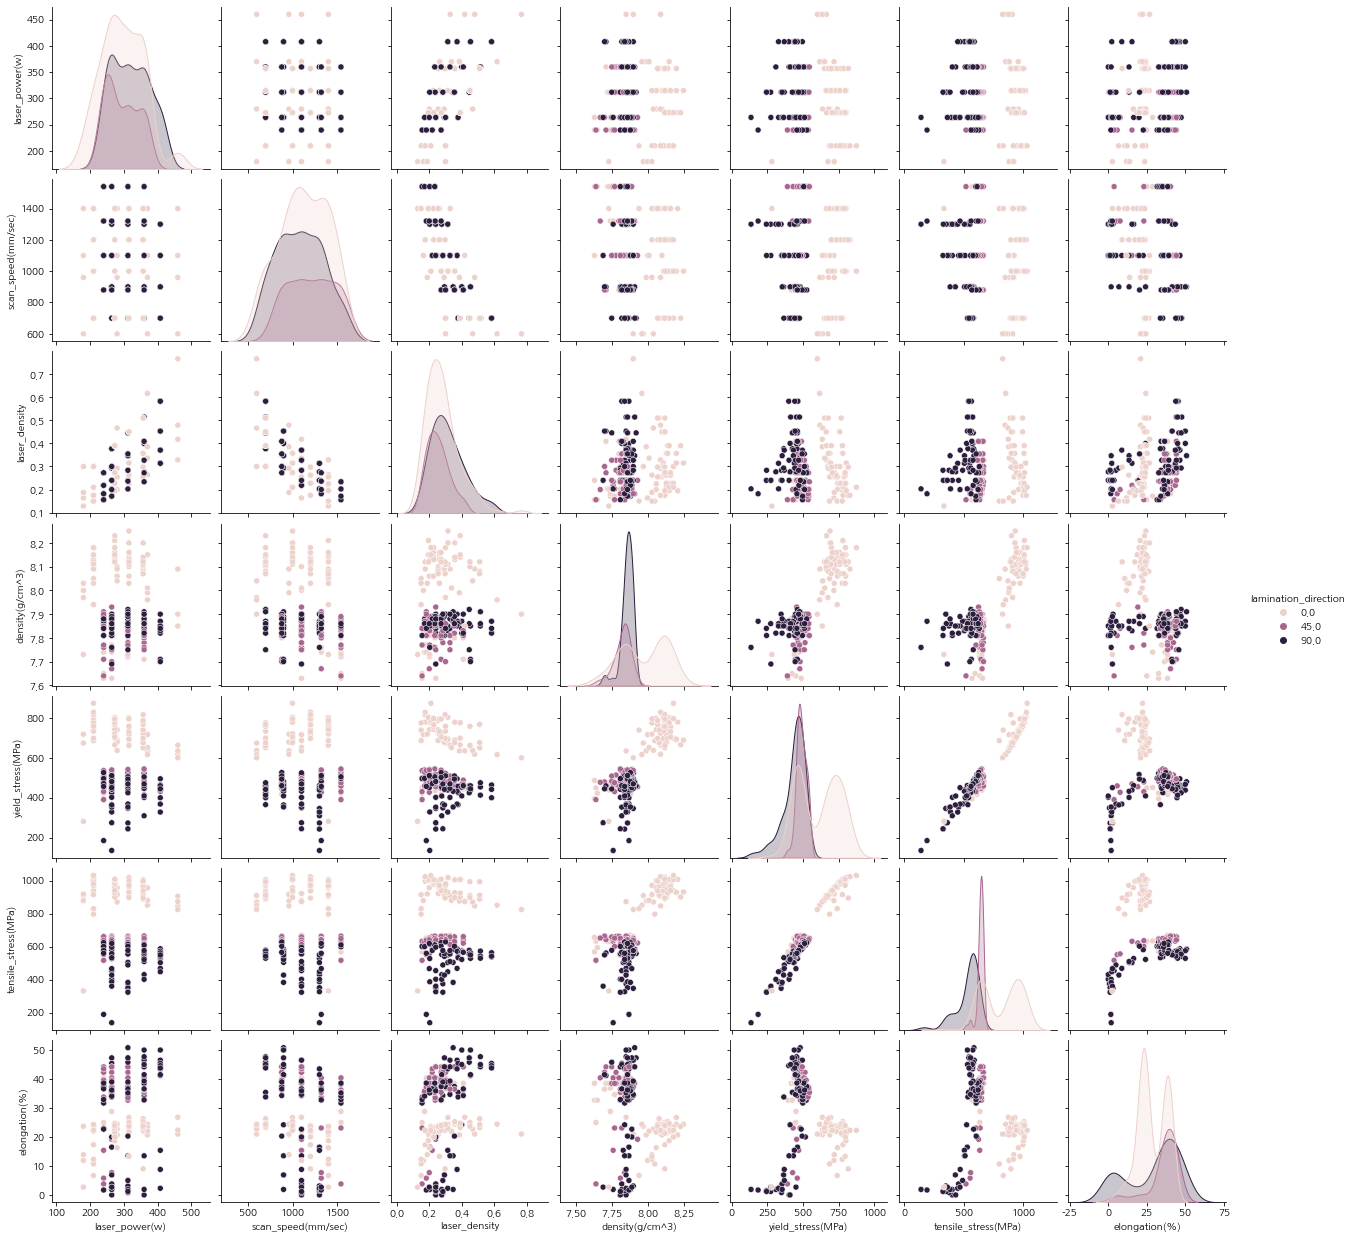

In [13]:
sns.pairplot(df, 
             x_vars=['laser_power(w)','scan_speed(mm/sec)','laser_density', 'density(g/cm^3)','yield_stress(MPa)','tensile_stress(MPa)','elongation(%)'],
             y_vars=['laser_power(w)','scan_speed(mm/sec)','laser_density', 'density(g/cm^3)','yield_stress(MPa)','tensile_stress(MPa)','elongation(%)'],
             hue='lamination_direction')

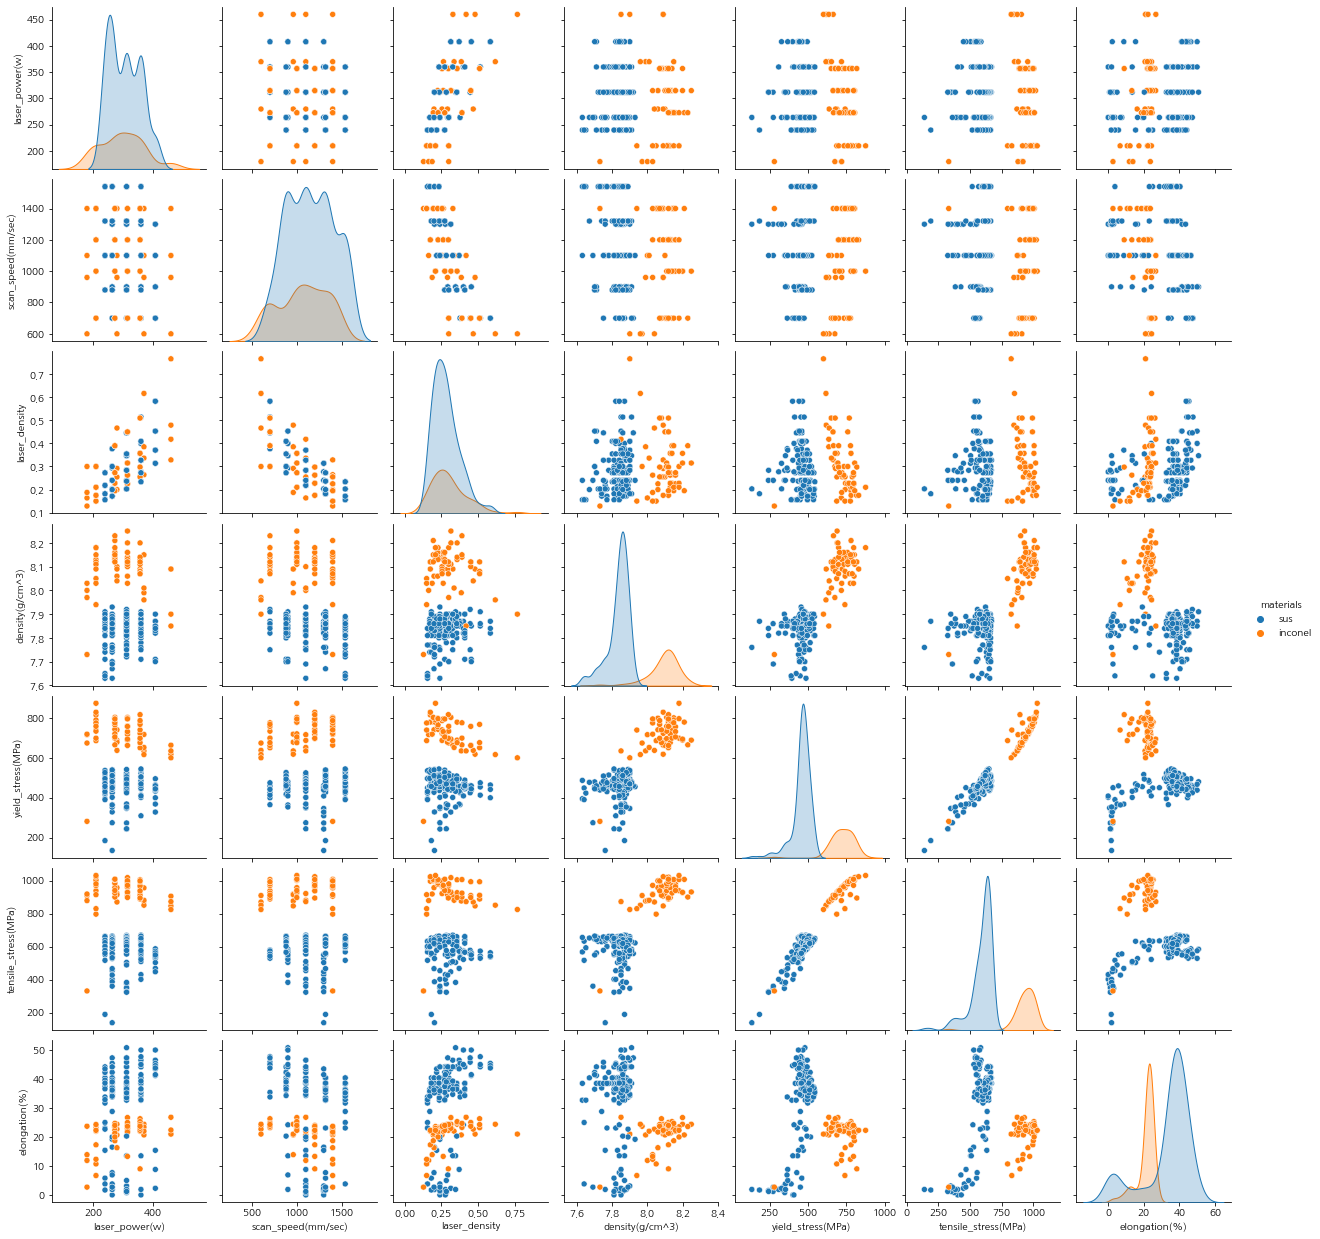

In [14]:
sns.pairplot(df, 
             x_vars=['laser_power(w)','scan_speed(mm/sec)','laser_density', 'density(g/cm^3)','yield_stress(MPa)','tensile_stress(MPa)','elongation(%)'],
             y_vars=['laser_power(w)','scan_speed(mm/sec)','laser_density', 'density(g/cm^3)','yield_stress(MPa)','tensile_stress(MPa)','elongation(%)'],
             hue='materials')

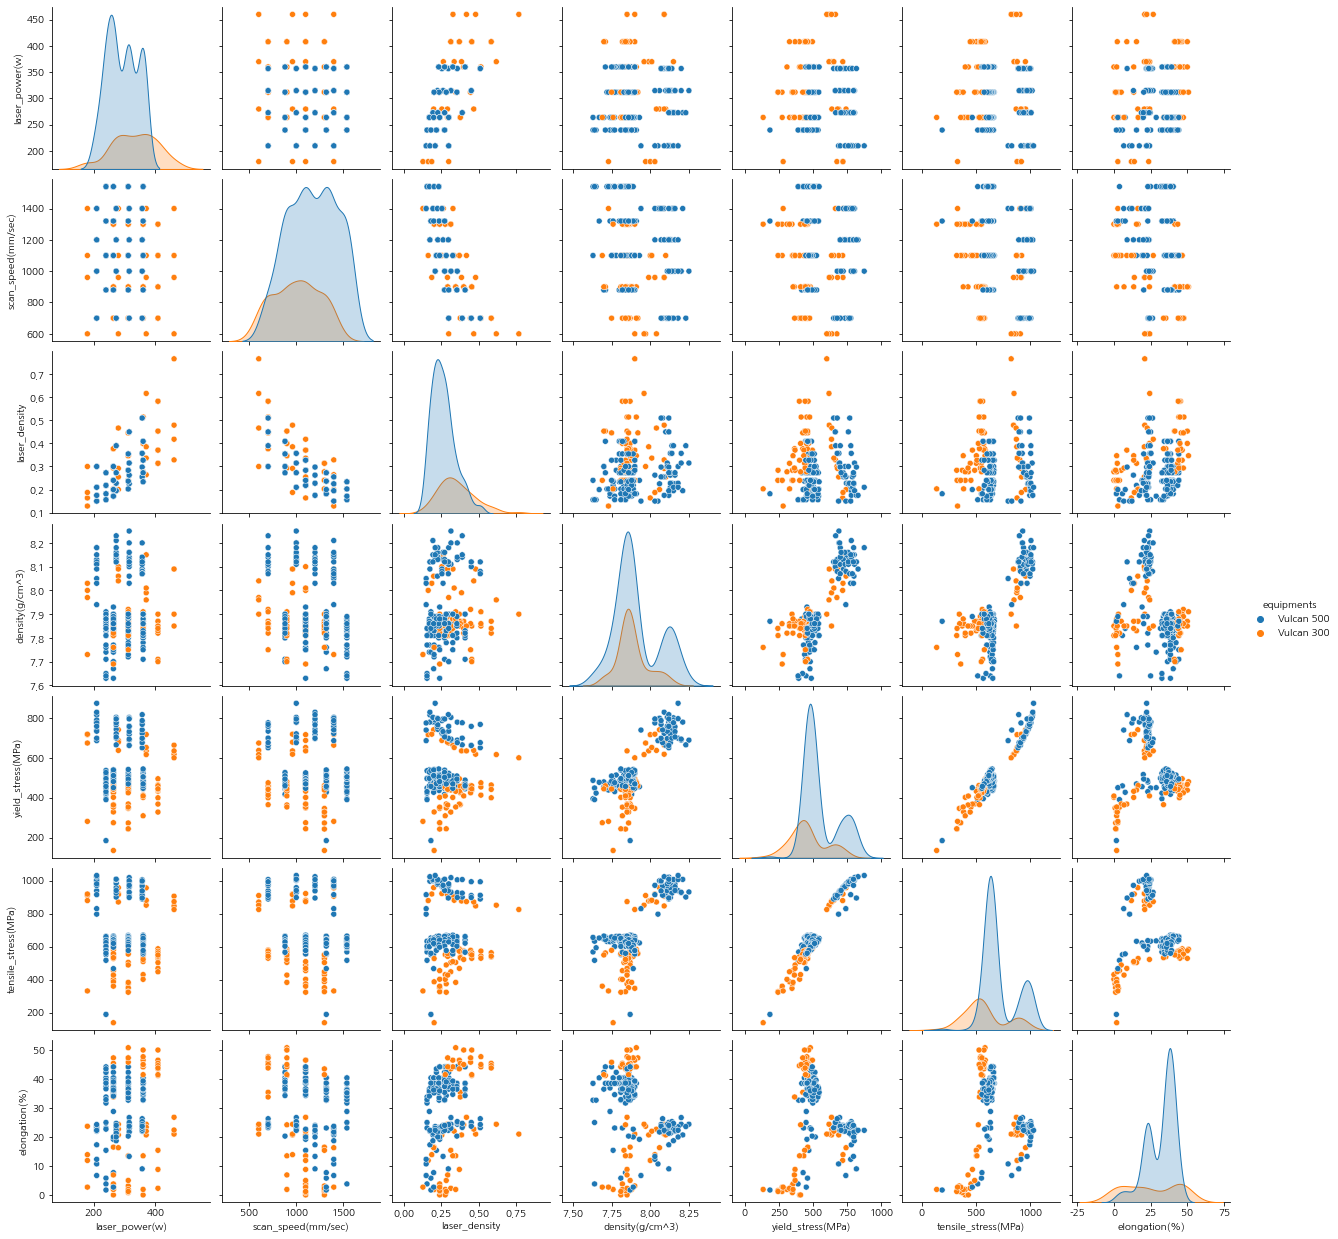

In [15]:
sns.pairplot(df, 
             x_vars=['laser_power(w)','scan_speed(mm/sec)','laser_density', 'density(g/cm^3)','yield_stress(MPa)','tensile_stress(MPa)','elongation(%)'],
             y_vars=['laser_power(w)','scan_speed(mm/sec)','laser_density', 'density(g/cm^3)','yield_stress(MPa)','tensile_stress(MPa)','elongation(%)'],
             hue='equipments')

In [16]:
# sns.pairplot(df, 
#              x_vars=['laser_power(w)','scan_speed(mm/sec)','laser_density', 'density(g/cm^3)','yield_stress(MPa)','tensile_stress(MPa)','elongation(%)'],
#              y_vars=['laser_power(w)','scan_speed(mm/sec)','laser_density', 'density(g/cm^3)','yield_stress(MPa)','tensile_stress(MPa)','elongation(%)'],
#              hue='trial_no')

### Check Images

In [17]:
# ncols = 5
# nrows = int(np.ceil(df.shape[0]/ncols))
# fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
# axes = axes.flatten()
# for idx in range(df.shape[0]): 
#     plt.sca(axes[idx])
#     avg_imgs = list()
#     img_list = list()
#     image_dir_list = df.iloc[idx]['image_dir']
#     idx_choice = [k for k in range(len(image_dir_list))]
#     random.shuffle(idx_choice)
#     idx_choice = idx_choice[::min(100, len(idx_choice))]
#     for i in idx_choice:
#         dir_img = image_dir_list[i]
#         img = cv2.imread(dir_img)
#         if img is None:
#             image_dir_list.remove(dir_img)
#         else:
#             img_list.append(np.expand_dims(img, axis=3))

#     avg_img = np.array(np.concatenate(img_list, axis=3).mean(axis=3) / 256, dtype=np.float32)
#     avg_img = cv2.cvtColor(avg_img, cv2.COLOR_BGR2RGB)
#     plt.imshow(avg_img)
#     plt.title(f"{df.iloc[idx]['materials']}_{int(df.iloc[idx]['lamination_direction'])}_{int(df.iloc[idx]['trial_no'])}cycle_{df.iloc[idx]['laser_power(w)']}_{df.iloc[idx]['scan_speed(mm/sec)']}")
#     df.iloc[idx]['image_dir'] = image_dir_list



# Train Model

## data preparation

In [18]:
_df = df.copy()
display(len(_df))
_df.head()

240

,materials,equipments,sample_num,layer_num,laser_power(w),scan_speed(mm/sec),density(g/cm^3),yield_stress(MPa),tensile_stress(MPa),elongation(%),lamination_direction,trial_no,image_dir,laser_density
0,sus,Vulcan 500,433.0,274,240.0,1540.0,7.64,449.14,633.20,25.0,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/433_5_sus_0_1cycle/Off_Axis_Images/0165_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/433_5_sus_0_1cycle/Off_Axis_Images/0218_06.bmp, /data/mygenie/AI_DB_CYA...",0.155844
1,sus,Vulcan 500,434.0,274,264.0,1540.0,7.74,450.59,635.25,28.8,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/434_5_sus_0_1cycle/Off_Axis_Images/0148_03.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/434_5_sus_0_1cycle/Off_Axis_Images/0107_09.bmp, /data/mygenie/AI_DB_CYA...",0.171429
2,sus,Vulcan 500,435.0,274,312.0,1540.0,7.72,448.42,632.19,38.5,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/435_5_sus_0_1cycle/Off_Axis_Images/0148_03.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/435_5_sus_0_1cycle/Off_Axis_Images/0267_06.bmp, /data/mygenie/AI_DB_CYA...",0.202597
3,sus,Vulcan 500,436.0,274,360.0,1540.0,7.80,453.55,639.41,38.5,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/436_5_sus_0_1cycle/Off_Axis_Images/0267_06.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/436_5_sus_0_1cycle/Off_Axis_Images/0264_09.bmp, /data/mygenie/AI_DB_CYA...",0.233766
4,sus,Vulcan 500,437.0,274,240.0,1320.0,7.74,473.84,629.69,36.9,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/437_5_sus_0_1cycle/Off_Axis_Images/0165_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/437_5_sus_0_1cycle/Off_Axis_Images/0267_06.bmp, /data/mygenie/AI_DB_CYA...",0.181818


In [19]:
prop_cols = ['yield_stress(MPa)', 'tensile_stress(MPa)', 'elongation(%)', 'density(g/cm^3)', ]
cond_cols = [
#     'materials', 'equitments', 
    'lamination_direction', 'laser_power(w)', 'scan_speed(mm/sec)', 'laser_density'
]

In [20]:
n_train = int(_df.shape[0] * 0.8 // 4) * 4
n_val = int(_df.shape[0] * 0.1 // 4) *4
is_train = np.array([i for i in range(len(_df))])
np.random.shuffle(is_train)
df_train = _df.iloc[is_train[:n_train], :]
df_val = df.iloc[is_train[n_train:n_train+n_val], :]
df_test = _df.iloc[is_train[n_train+n_val:], :]

In [21]:
print(f'n_train: {df_train.shape[0]}')
display(df_train.head(10))

n_train: 192


,materials,equipments,sample_num,layer_num,laser_power(w),scan_speed(mm/sec),density(g/cm^3),yield_stress(MPa),tensile_stress(MPa),elongation(%),lamination_direction,trial_no,image_dir,laser_density
223,sus,Vulcan 500,286.0,1995,264.0,1320.0,7.86,539.80,641.81,36.9,45.0,3.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/8.sus_45_3cycle_process/SIDE/IMAGE/0/0286_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/8.sus_45_3cycle_process/SIDE/IMAGE/0/0403_09.bmp, /data/m...",0.200000
110,sus,Vulcan 300,277.0,2549,264.0,1100.0,7.82,352.93,454.68,3.8,90.0,2.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_2_process/SIDE/IMAGE/0/0286_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_2_process/SIDE/IMAGE/0/0403_09.bmp, /data/mygenie/A...",0.240000
152,sus,Vulcan 500,2193.0,2549,312.0,880.0,7.89,509.54,618.24,37.4,90.0,3.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/11.sus_90_3cycle_process/SIDE/IMAGE/0/0669_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/11.sus_90_3cycle_process/SIDE/IMAGE/0/0286_08.bmp, /data...",0.354545
7,sus,Vulcan 500,440.0,274,360.0,1320.0,7.85,469.92,641.53,38.5,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/440_5_sus_0_1cycle/Off_Axis_Images/0259_02.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/440_5_sus_0_1cycle/Off_Axis_Images/0148_03.bmp, /data/mygenie/AI_DB_CYA...",0.272727
69,sus,Vulcan 500,502.0,1995,264.0,1100.0,7.75,483.22,658.94,44.2,45.0,2.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/502_5_sus_45_2cycle/Off_Axis_Images/0400_07.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/502_5_sus_45_2cycle/Off_Axis_Images/0402_06.bmp, /data/mygenie/AI_DB_C...",0.240000
77,sus,Vulcan 500,510.0,1995,264.0,1540.0,7.85,459.17,625.21,34.6,45.0,2.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/510_5_sus_45_2cycle/Off_Axis_Images/0293_05.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/510_5_sus_45_2cycle/Off_Axis_Images/0473_04.bmp, /data/mygenie/AI_DB_C...",0.171429
165,inconel,Vulcan 500,286.0,324,273.0,700.0,8.23,665.91,900.93,23.6,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/3. 5_Inconel_0_1_process/SIDE/IMAGE/0/0286_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/3. 5_Inconel_0_1_process/SIDE/IMAGE/0/0277_06.bmp, /data...",0.390000
39,sus,Vulcan 500,472.0,274,360.0,1320.0,7.86,497.92,662.69,38.5,0.0,3.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/472_5_sus_0_3cycle/Off_Axis_Images/0267_06.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/472_5_sus_0_3cycle/Off_Axis_Images/0218_06.bmp, /data/mygenie/AI_DB_CYA...",0.272727
95,sus,Vulcan 300,286.0,2549,312.0,1100.0,7.85,348.79,374.72,0.8,90.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_1_process/SIDE/IMAGE/0/0286_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_1_process/SIDE/IMAGE/0/0403_09.bmp, /data/mygenie/A...",0.283636
65,sus,Vulcan 500,498.0,1995,264.0,880.0,7.70,479.76,664.54,42.3,45.0,2.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/498_5_sus_45_2cycle/Off_Axis_Images/0400_07.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/498_5_sus_45_2cycle/Off_Axis_Images/0402_06.bmp, /data/mygenie/AI_DB_C...",0.300000


In [22]:
print(f'n_val: {df_val.shape[0]}')
display(df_val.head(10))

n_val: 24


,materials,equipments,sample_num,layer_num,laser_power(w),scan_speed(mm/sec),density(g/cm^3),yield_stress(MPa),tensile_stress(MPa),elongation(%),lamination_direction,trial_no,image_dir,laser_density
63,sus,Vulcan 500,496.0,1995,360.0,1540.0,7.76,469.00,645.35,40.4,45.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/496_5_sus_45_1cycle/Off_Axis_Images/0148_03.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/496_5_sus_45_1cycle/Off_Axis_Images/0470_04.bmp, /data/mygenie/AI_DB_C...",0.233766
220,sus,Vulcan 500,286.0,1995,312.0,1100.0,7.83,495.66,625.53,38.5,45.0,3.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/8.sus_45_3cycle_process/SIDE/IMAGE/0/0286_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/8.sus_45_3cycle_process/SIDE/IMAGE/0/0403_09.bmp, /data/m...",0.283636
29,sus,Vulcan 500,462.0,274,264.0,880.0,7.70,454.61,645.98,36.5,0.0,2.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/462_5_sus_0_2cycle/Off_Axis_Images/0165_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/462_5_sus_0_2cycle/Off_Axis_Images/0150_03.bmp, /data/mygenie/AI_DB_CYA...",0.300000
92,sus,Vulcan 300,286.0,2549,360.0,900.0,7.87,467.46,575.03,50.0,90.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_1_process/SIDE/IMAGE/0/0286_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_1_process/SIDE/IMAGE/0/0403_09.bmp, /data/mygenie/A...",0.400000
18,sus,Vulcan 500,451.0,274,312.0,1540.0,7.81,468.29,625.68,38.5,0.0,2.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/451_5_sus_0_2cycle/Off_Axis_Images/0148_03.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/451_5_sus_0_2cycle/Off_Axis_Images/0165_08.bmp, /data/mygenie/AI_DB_CYA...",0.202597
50,sus,Vulcan 500,483.0,1995,312.0,880.0,7.82,458.76,639.12,44.2,45.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/483_5_sus_45_1cycle/Off_Axis_Images/0400_07.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/483_5_sus_45_1cycle/Off_Axis_Images/0165_08.bmp, /data/mygenie/AI_DB_C...",0.354545
179,inconel,Vulcan 500,286.0,324,357.0,1000.0,8.13,676.87,898.16,25.0,0.0,2.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/4. 5_Inconel_0_2_process/SIDE/IMAGE/0/0277_06.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/4. 5_Inconel_0_2_process/SIDE/IMAGE/0/0088_05.bmp, /data...",0.357000
205,inconel,Vulcan 500,286.0,324,357.0,1200.0,8.12,817.78,895.06,9.0,0.0,3.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/5. 5_Inconel_0_3_process/SIDE/IMAGE/0/0286_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/5. 5_Inconel_0_3_process/SIDE/IMAGE/0/0277_06.bmp, /data...",0.297500
116,sus,Vulcan 300,286.0,2549,264.0,1300.0,7.76,134.86,138.96,1.9,90.0,3.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_3_process/SIDE/IMAGE/0/0286_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_3_process/SIDE/IMAGE/0/0403_09.bmp, /data/mygenie/A...",0.203077
144,sus,Vulcan 500,669.0,2549,240.0,880.0,7.89,505.41,608.81,39.0,90.0,3.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/11.sus_90_3cycle_process/SIDE/IMAGE/0/0669_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/11.sus_90_3cycle_process/SIDE/IMAGE/0/0286_08.bmp, /data...",0.272727


In [23]:
print(f'n_test: {df_test.shape[0]}')
display(df_test.head(10))

n_test: 24


,materials,equipments,sample_num,layer_num,laser_power(w),scan_speed(mm/sec),density(g/cm^3),yield_stress(MPa),tensile_stress(MPa),elongation(%),lamination_direction,trial_no,image_dir,laser_density
164,inconel,Vulcan 500,88.0,324,210.0,700.0,8.18,699.48,939.43,23.5,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/3. 5_Inconel_0_1_process/SIDE/IMAGE/0/0286_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/3. 5_Inconel_0_1_process/SIDE/IMAGE/0/0277_06.bmp, /data...",0.300000
103,sus,Vulcan 300,286.0,2549,408.0,1300.0,7.83,438.88,503.68,15.4,90.0,2.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_2_process/SIDE/IMAGE/0/0286_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_2_process/SIDE/IMAGE/0/0403_09.bmp, /data/mygenie/A...",0.313846
231,sus,Vulcan 500,669.0,2549,360.0,1540.0,7.86,505.21,610.68,38.6,90.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/9.sus_90_1cycle_process/SIDE/IMAGE/0/2193_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/9.sus_90_1cycle_process/SIDE/IMAGE/0/0669_08.bmp, /data/m...",0.233766
14,sus,Vulcan 500,447.0,274,312.0,880.0,7.80,447.67,633.87,38.5,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/447_5_sus_0_1cycle/Off_Axis_Images/0259_02.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/447_5_sus_0_1cycle/Off_Axis_Images/0218_06.bmp, /data/mygenie/AI_DB_CYA...",0.354545
1,sus,Vulcan 500,434.0,274,264.0,1540.0,7.74,450.59,635.25,28.8,0.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/434_5_sus_0_1cycle/Off_Axis_Images/0148_03.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/434_5_sus_0_1cycle/Off_Axis_Images/0107_09.bmp, /data/mygenie/AI_DB_CYA...",0.171429
57,sus,Vulcan 500,490.0,1995,264.0,1320.0,7.84,427.37,556.23,7.7,45.0,1.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/490_5_sus_45_1cycle/Off_Axis_Images/0400_07.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/490_5_sus_45_1cycle/Off_Axis_Images/0165_08.bmp, /data/mygenie/AI_DB_C...",0.200000
100,sus,Vulcan 300,286.0,2549,264.0,1300.0,7.86,328.47,387.13,1.9,90.0,2.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_2_process/SIDE/IMAGE/0/0286_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_2_process/SIDE/IMAGE/0/0403_09.bmp, /data/mygenie/A...",0.203077
109,sus,Vulcan 300,277.0,2549,408.0,900.0,7.71,459.98,562.08,41.2,90.0,2.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_2_process/SIDE/IMAGE/0/0286_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/300장비/1. sus_90_2_process/SIDE/IMAGE/0/0403_09.bmp, /data/mygenie/A...",0.453333
67,sus,Vulcan 500,500.0,1995,360.0,880.0,7.85,488.90,661.31,44.2,45.0,2.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220720/500_5_sus_45_2cycle/Off_Axis_Images/0215_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220720/500_5_sus_45_2cycle/Off_Axis_Images/0286_08.bmp, /data/mygenie/AI_DB_C...",0.409091
199,inconel,Vulcan 500,286.0,324,357.0,700.0,8.07,768.78,993.57,24.3,0.0,3.0,"[/data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/5. 5_Inconel_0_3_process/SIDE/IMAGE/0/0286_08.bmp, /data/mygenie/AI_DB_CYAUTOTECH/220905/500장비/5. 5_Inconel_0_3_process/SIDE/IMAGE/0/0277_06.bmp, /data...",0.510000


In [24]:
def sample_to_sub_dir(sample : pd.Series, ):
    sample_num = sample['sample_num']
    material = sample['materials'].lower()
    lam_dir = int(sample['lamination_direction'])
    trial_no = int(sample['trial_no'])
    
    return f'{sample_num}_5_{material}_{lam_dir}_{trial_no}cycle'


def read_avg_image(image_dir_list, num_img=100):
    avg_imgs = list()
    img_list = list()
    
    idx_choice = [k for k in range(len(image_dir_list))]
    random.shuffle(idx_choice)
    idx_choice = idx_choice[::min(100, len(idx_choice))]
    for i in idx_choice:
        dir_img = image_dir_list[i]
        img = cv2.imread(dir_img)
        if img is None:
            image_dir_list.remove(dir_img)
        else:
            img_list.append(np.expand_dims(img, axis=3))

    avg_img = np.array(np.concatenate(img_list, axis=3).mean(axis=3) / 256, dtype=np.float32)
    avg_img = cv2.cvtColor(avg_img, cv2.COLOR_BGR2RGB)    
    return avg_img 


In [25]:
class SpecimenDataset(Dataset):
    
    def __init__(self, df, 
                 transform_x=None, 
                 transform_x_img=None,
                 transform_y=None):
        self.df = df
        self.transform_x = transform_x
        self.transform_x_img = transform_x_img
        self.transform_y = transform_y
        
    def __getitem__(self, idx):
        
        sample = self.df.iloc[idx, :]
        sample_num = sample['sample_num']
        
        x = sample[cond_cols].values
        y = sample[prop_cols].values
        
        sub_dir = sample_to_sub_dir(sample)
        img_dir = sample['image_dir']
        x_img = read_avg_image(img_dir)
        x_img = x_img.transpose(2,0,1)        
        
        if self.transform_x is not None:
            x = np.array(self.transform_x(x), dtype=np.float32)
            
        if self.transform_x_img is not None:
            x_img = np.array(self.transform_x_img(x_img), dtype=np.float32)
            
        if self.transform_y is not None:
            y = np.array(self.transform_y(y), dtype=np.float32)
    
        return (x, x_img, y, sample_num, idx)
        #return (x.astype(np.float32), x_img.astype(np.float32), y.astype(np.float32), sample_num, idx)
    
    
    def __len__(self):
        return len(self.df)
        
        
class Normalizer:
    """
    최소/최대 [-1, 1] 범위로 정규화
    """ 
    def __init__(self, mins=np.zeros(0), maxs=np.zeros(0), diffs=np.ones(0)):
        self.mins = mins
        self.maxs = maxs
        self.diffs = diffs
        
    def fit(self, array):
        self.mins = array.min(axis=0)
        self.maxs = array.max(axis=0)
        self.diffs = (self.maxs - self.mins) * 0.5
        
        return self
        
    def __call__(self, sample):
        return (sample - self.mins) / self.diffs - 1
    
    def inverse_tranform(self, normalized):
        return (normalized + 1) * self.diffs[None, :] + self.mins[None, :]


class Standardizer:
    """
    정규화
    """ 
    def __init__(self, means=np.zeros(0), stds=np.ones(0)):
        self.means = means
        self.stds = stds
        
    def fit(self, array):
        self.means = array.mean(axis=0)
        self.stds = array.std(axis=0)
        
        self.stds[self.stds == 0] = 1
        
        return self
        
    def __call__(self, sample):
        return (sample - self.means) / self.stds
    
    def inverse_tranform(self, normalized):
        return normalized * self.stds[None, :] + self.means[None, :]


In [26]:
normalizer_x = Standardizer().fit(df_train[cond_cols].values)
normalizer_y = Standardizer().fit(df_train[prop_cols].values)

transform_x = Compose([normalizer_x])
transform_y = Compose([normalizer_y])

In [27]:
## 이미지의 경우 대다수의 픽셀이 0, 불꽃 부위만 256에 가까운 값을 가져서, [-1, 1] 범위로 변환만 함

#transform_x_img = Compose([Lambda(lambda x: x / 256. * 2 - 1)])
transform_x_img = Compose([Lambda(lambda x: x *2 -1 )])

In [28]:
train_dataset = SpecimenDataset(df_train, transform_x=transform_x, transform_x_img=transform_x_img, transform_y=transform_y)
test_dataset = SpecimenDataset(df_test, transform_x=transform_x, transform_x_img=transform_x_img, transform_y=transform_y)
val_dataset = SpecimenDataset(df_val, transform_x=transform_x, transform_x_img=transform_x_img, transform_y=transform_y)

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from resnet import ResNet, BasicBlock
from munch import Munch

#torch.backends.cudnn.enabled=False

class DataModule(pl.LightningDataModule):
    def __init__(self, params, train_dataset, test_dataset, val_dataset=None):
        super().__init__()

        self.train = train_dataset
        self.val = val_dataset
        self.test = test_dataset
        
    def train_dataloader(self, shuffle=True, drop_last=True):
        train_loader = DataLoader(dataset=self.train, 
                                  batch_size=params.batch_size, 
                                  num_workers=params.num_workers,
                                  shuffle=shuffle,
                                  drop_last=drop_last)
        return train_loader
            
    def val_dataloader(self, shuffle=False, drop_last=True):
        if self.val:
            val_loader = DataLoader(dataset=self.val, 
                                    batch_size=params.batch_size, 
                                    num_workers=params.num_workers,
                                    shuffle=shuffle,
                                    drop_last=drop_last)
            return val_loader
        else:
            return None
            
    def test_dataloader(self, shuffle=False, drop_last=True):
        test_loader = DataLoader(dataset=self.test, 
                        batch_size=params.batch_size, #self.test.__len__(), 
                        num_workers=params.num_workers,
                        shuffle=shuffle,
                        drop_last=drop_last)
        return test_loader

def create_model():
    return ResNet(BasicBlock, [1,1,1,1], num_classes=1)
#return _resnet("resnet", BasicBlock, [1,1,1,1], pretrained=False, progress=False, num_classes=1)

class RegressionModule(LightningModule):
    def __init__(self, params):
        super().__init__()
        self.learning_rate = params.learning_rate
        self.weight_decay = params.weight_decay
        self.output_size = params.output_size
        self.input_size = params.input_size
        self.hidden_size = params.hidden_size
        self.num_layers = params.num_layers
        
        #self.img_encoder = create_model()
        self.img_encoder = ResNet(BasicBlock, [1,1,1,1], num_classes=256)
        #self.model = _resnet("resnet", BasicBlock, [1,1,1,1], pretrained=False, progress=False, num_classes=1)
        
        inp_encoder = [
            nn.Linear(self.input_size, 16), nn.ReLU(), nn.Dropout(params.dropout), 
        ]
        self.inp_encoder = nn.Sequential( *inp_encoder )
        layers = [
            nn.Linear(272, 128), nn.ReLU(), nn.Dropout(params.dropout), 
            nn.Linear(128, 32), nn.ReLU(), nn.Dropout(params.dropout), 
            nn.Linear(32, self.output_size),
        ]
        self.layers = nn.Sequential( *layers )
      
    
    def forward(self, x_inp, x_img, ): #[B,L,I]
        
        out_img = self.img_encoder(x_img)
        out_inp = self.inp_encoder(x_inp)
        out = torch.cat((out_img.view(-1, 256), out_inp.view(-1, 16)), dim=-1)
        return self.layers(out)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=self.learning_rate, 
                                     weight_decay=self.weight_decay) 
        return optimizer
    
    def _step(self, batch, mode='train'):
        x_inp, x_img, y, sample_num, idx = batch
        
        if torch.cuda.is_available():
            x_inp, x_img, y = x_inp.cuda(), x_img.cuda(), y.cuda()
        y_pred = self.forward(x_inp, x_img)
        loss = F.mse_loss(y_pred, y)
        self.log('{}_loss'.format(mode), loss)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self._step(batch, mode='train')
    
    def validation_step(self, batch, batch_idx):
        return self._step(batch, mode='val')
    
    def test_step(self, batch, batch_idx):
        return self._step(batch, mode='test')

    
def he_init(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

def to_gpu(module):
    device = torch.cuda.current_device()
    module.to(device)

In [30]:
#from sklearn.metrics import mean_absolute_percentage_error 
from scipy import stats
from sklearn.metrics import r2_score 
import seaborn as sns
import warnings 
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = "notebook"

warnings.simplefilter(action='ignore', category=FutureWarning)

def evaluation(model, test_loader):
    y_real = list()
    y_pred = list()
    x_real = list()
    with torch.no_grad():
        if params.gpu:
            model = model.cuda()
        for batch in test_loader:
            x_inp, x_img, y, sample_num, idx = batch
            if params.gpu:
                x_inp, x_img, y = x_inp.cuda(), x_img.cuda(), y.cuda()

            y_real.extend(y.data.cpu().numpy())
            x_real.append(x_inp.data.cpu().numpy())
            _y_pred = model.forward(x_inp, x_img)
            y_pred.extend(_y_pred.data.cpu().numpy())

    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(-1)
    y_real = np.array(y_real)
    y_real = y_real.reshape(-1)
    x_real = np.array(x_real)
    x_real = x_real.reshape((-1, x_real.shape[-1]))
    print(x_real.shape, y_pred.shape, y_real.shape)
    
    return y_pred, y_real, x_real


def cal_mape(y_pred, y_real):
    #return mean_absolute_percentage_error(y_real, y_pred) * 100
    #non_zero = np.where(y_real != 0.0)
    non_zero = np.where(np.abs(y_real) > 1e-6)
    out = np.abs(np.divide((y_pred[non_zero] - y_real[non_zero]), y_real[non_zero]))
    return np.nansum(out) / (y_real.shape[0]) * 100

def cal_rmse(y_pred, y_real):
    non_zero = np.where(np.abs(y_real) > 1e-6)
    out = np.sqrt( np.sum(np.square((y_pred[non_zero] - y_real[non_zero])))/ (y_real.shape[0]))
    return out

def cal_r2(y_pred, y_real):
    return r2_score(y_real, y_pred)
#     ss_res = np.sum( np.square(y_real - y_pred) ) 
#     ss_tot = np.sum( np.square(y_real - np.mean(y_real)))
#     return 1 - ss_res / ss_tot

def cal_spearmanr(y_pred, y_real):
    return stats.spearmanr(y_pred, y_real, nan_policy='omit') 

def plotly_compact(data, title=None, static=True, xdata=None):
    fig = make_subplots()
    for key, val in data.items():
        if xdata is None:
            fig.add_trace(go.Scatter(y=val, name=key))
        else:
            fig.add_trace(go.Scatter(x=xdata, y=val, name=key))
            
    _layout_dict = dict()
    if title:
        _layout_dict['title'] = title
    #_layout_dict['yaxis'] = dict(range=[750, 1050 ],)
    #_layout_dict['xaxis'] = dict(range=[17350, 17850],)

    if static:
        _layout_dict['width'] = 1600
        fig.update_layout(_layout_dict)
        fig.show(renderer="png")  
    else:
        fig.update_layout(_layout_dict)
        fig.show()
    

def summarize(model, trainer, params, data_module, dataset=None, static_plot=True): 
    #mse = trainer.test(model)
    dm_loaders = Munch( train = data_module.train_dataloader(shuffle=False), 
                        val = data_module.val_dataloader(shuffle=False), 
                        test = data_module.test_dataloader(shuffle=False))
    if dataset:
        df_set = Munch( train = dataset.train, 
                        val = dataset.val, 
                        test = dataset.test )
    print('experiment {}'.format(params.exp_title))
    print('-'*20)
    exp_results = list()
    #fig = plt.figure(figsize=(6*5, 6*2))
    #axes = fig.subplots(1,1, sharey=True).flatten()
    exp_results = pd.DataFrame([])
    tag_mode = ['train', 'val', 'test'] #'val'
    for mode in tag_mode:  
        y_pred, y_real, x_real = evaluation(model, dm_loaders[mode])   
        df_results = Munch(
            #predicted = np.array( [inverse_transform(y, dataset.scaler, idx_y) for y in y_pred[:,i] ]), 
            #real = np.array( [inverse_transform(y, dataset.scaler, idx_y) for y in y_real[:,i] ]), 
            predicted = y_pred ,
            real = y_real
        )
        
        mape = cal_mape(df_results.predicted, df_results.real)
        rmse = cal_rmse(df_results.predicted, df_results.real)
        r2 = cal_r2(df_results.predicted, df_results.real)
        spearmanr = cal_spearmanr(df_results.predicted, df_results.real)
        title = '[{}] {}\n'.format(params.exp_title, mode)
        data = {
            'mode': mode,
            'mape': mape,
            'rmse': rmse,
            'r2': r2, 
            'spearmanr': '{}'.format(spearmanr),    
        }
        print('mape      ({}): {:.6f}'.format(mode, mape))
        print('rmse      ({}): {:.6f}'.format(mode, rmse))
        print('r2        ({}): {:.6f}'.format(mode, r2))
        print('spearmanr ({}): {}'.format(mode, spearmanr))
        if exp_results.shape[0] <= 0:
            exp_results = pd.DataFrame(data, index=[0])
        else:
            exp_results = pd.concat([exp_results, pd.DataFrame(data, index=[0])], ignore_index=True)
        plotly_compact(df_results, title=title, static=True, xdata=None)
        
    #plt.legend()
    #plt.show()
    print('experiment {}'.format(params.exp_title))

    models[params.exp_title] = model
    data_modules[params.exp_title] = data_module
    parameters[params.exp_title] = params
    #metric_mse[params.exp_title] = mse
    metric_mape[params.exp_title] = mape
    metric_r2[params.exp_title] = r2
    y_predictions[params.exp_title] = y_pred
    y_reals[params.exp_title] = y_real
    return exp_results

    
def search_model_ckpt(base_dir, exp_title):
    base_dir = os.path.join(os.getcwd(), base_dir)
    model_dir = os.path.join(base_dir, params.exp_title)
    print(sorted(os.listdir(model_dir)))
    model_dir = os.path.join(model_dir, sorted(os.listdir(model_dir))[-1])
    model_dir = os.path.join(model_dir, 'checkpoints')
    model_dir = os.path.join(model_dir, os.listdir(model_dir)[0])
    print(model_dir)
    return model_dir

In [31]:
parameters = Munch() 
y_predictions = Munch()
y_reals = Munch()
metric_mse = Munch()
metric_mape = Munch()
metric_r2 = Munch()
models = Munch()
data_modules = Munch()

log_base_dir = 'logs_resnet_off/'

In [32]:
prop_cols = ['yield_stress(MPa)', 'tensile_stress(MPa)', 'elongation(%)', 'density(g/cm^3)', ]
cond_cols = ['lamination_direction', 'laser_power(w)', 'scan_speed(mm/sec)', 'laser_density'] #'materials', 'equitments', 

In [33]:
params = Munch(
    window_size=1, 
    batch_size=8, #8, 
    num_workers=16,
    input_size=len(cond_cols), 
    output_size=len(prop_cols),
    hidden_size=32, 
    num_layers=4,
    learning_rate=2e-5,
    max_epochs=100,
    weight_decay=0.0,
    dropout=0.0,
    gpu=torch.cuda.is_available(),
    exp_title='ver05',
    is_train=True, 
    model_path=None,
    )

In [34]:
params.exp_title='ver05'
params.weight_decay=0.0
params.dropout=0.0

# params.is_train=False
# params.model_path=os.path.join(log_base_dir, params.exp_title),
data_module = DataModule(params, train_dataset, test_dataset, val_dataset)

In [35]:
def _build_model(params):
    model = RegressionModule(params)
    return model

def _init_model(params, model):
    if params.is_train:
        model.apply(he_init)       
        if params.gpu:
            model.apply(to_gpu)

    else:
        model_dir = search_model_ckpt(log_base_dir, params.exp_title)
        #model_dir = os.path.join(os.path.join(log_base_dir, params.exp_title),'epoch={}.ckpt'.format(params.max_epochs))
        model_ckpt = torch.load(model_dir)
        model.load_state_dict(model_ckpt['state_dict'])
        if params.gpu:
            model.apply(to_gpu)

In [36]:
model = _build_model(params)

if params.is_train:
    _init_model(params, model)
    trainer = pl.Trainer(
        gpus=1, auto_select_gpus=True, 
        max_epochs=params.max_epochs, 
        default_root_dir=os.path.join(log_base_dir, params.exp_title),
        logger=pl.loggers.TensorBoardLogger(log_base_dir, name=params.exp_title))
    trainer.fit(model, data_module)
    trainer.save_checkpoint(os.path.join(os.path.join(log_base_dir, params.exp_title),'epoch={}.ckpt'.format(params.max_epochs)))
else:
    _init_model(params, model)
    trainer = pl.Trainer(gpus=1, auto_select_gpus=True)

/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning:

Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.

Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs_resnet_off/ver05
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | img_encoder | ResNet     | 5.0 M 
1 | inp_encoder | Sequential | 80    
2 | layers      | Sequential | 39.2 K
-------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.306    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ysg/anaconda3/envs/aidb/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning:

The number of training batches (24) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


experiment ver05
--------------------
(192, 4) (768,) (768,)
mape      (train): 61.754799
rmse      (train): 0.396368
r2        (train): 0.842892
spearmanr (train): SpearmanrResult(correlation=0.9000664516615057, pvalue=1.4559769440645528e-278)


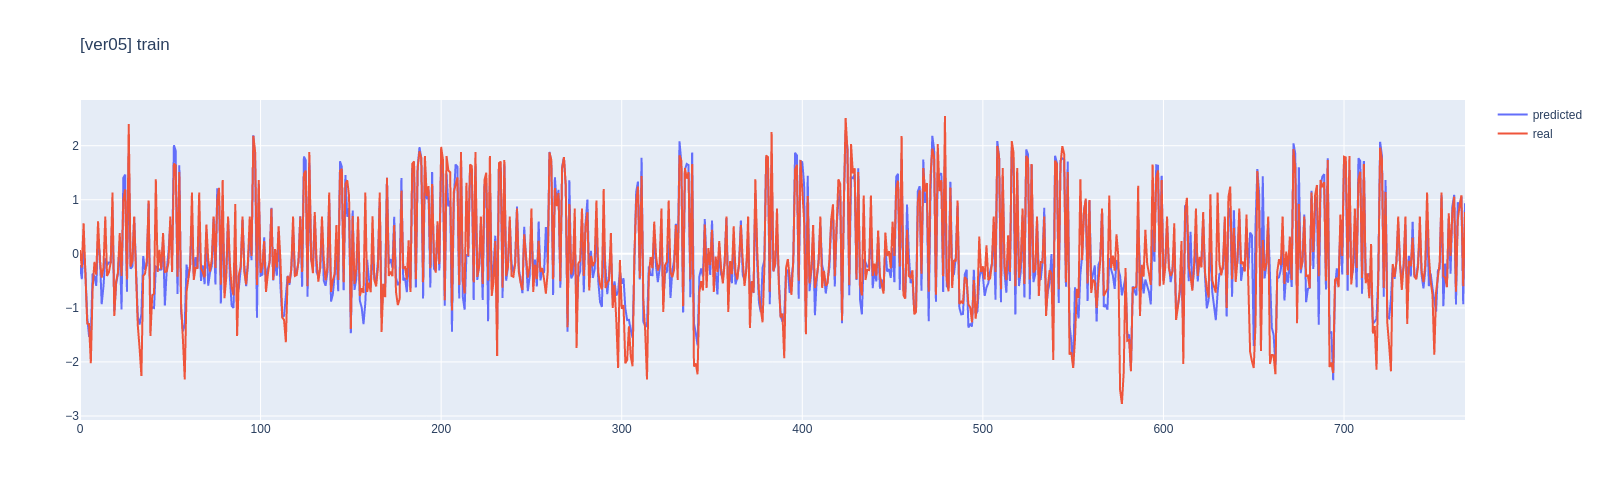

(24, 4) (96,) (96,)
mape      (val): 119.439411
rmse      (val): 0.468478
r2        (val): 0.765377
spearmanr (val): SpearmanrResult(correlation=0.8391457579530128, pvalue=1.3421171385800637e-26)


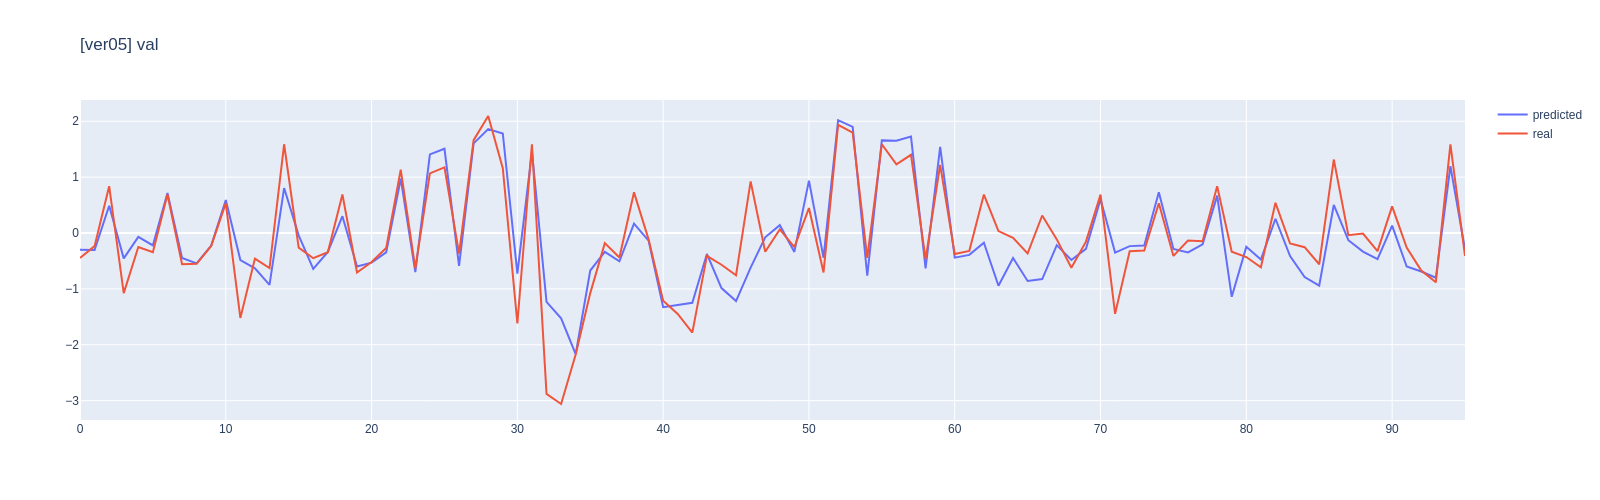

(24, 4) (96,) (96,)
mape      (test): 54.412381
rmse      (test): 0.395651
r2        (test): 0.818881
spearmanr (test): SpearmanrResult(correlation=0.8410753482538527, pvalue=7.977878528505212e-27)


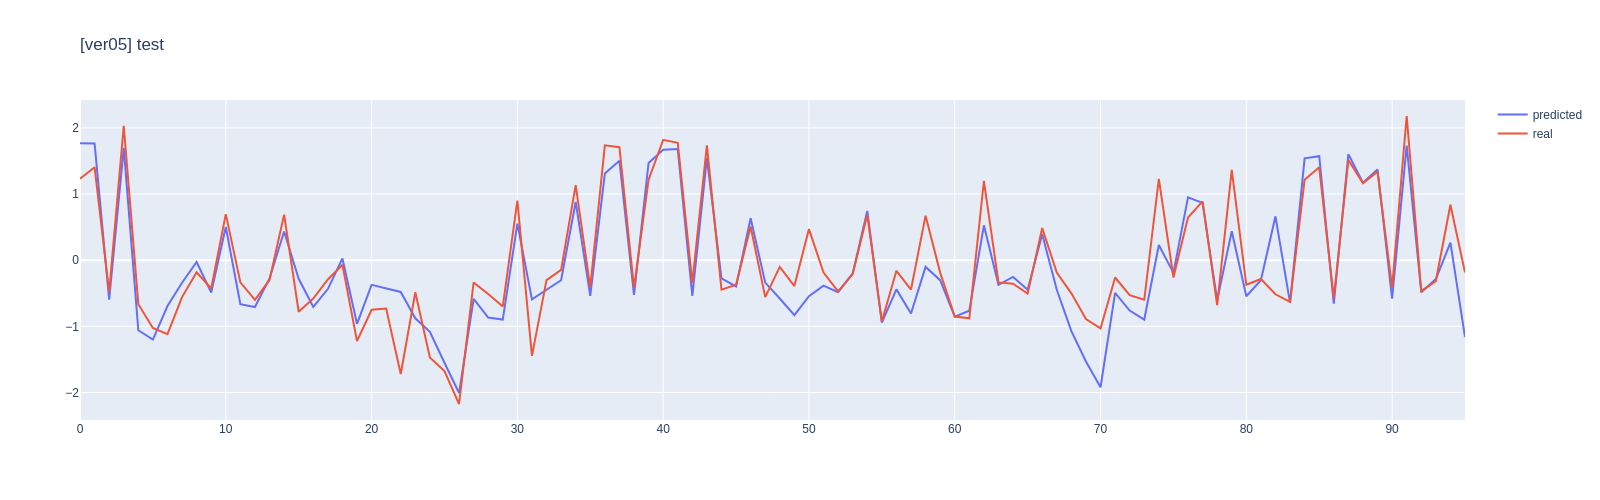

experiment ver05


,mode,mape,rmse,r2,spearmanr
0,train,61.754799,0.396368,0.842892,"SpearmanrResult(correlation=0.9000664516615057, pvalue=1.4559769440645528e-278)"
1,val,119.439411,0.468478,0.765377,"SpearmanrResult(correlation=0.8391457579530128, pvalue=1.3421171385800637e-26)"
2,test,54.412381,0.395651,0.818881,"SpearmanrResult(correlation=0.8410753482538527, pvalue=7.977878528505212e-27)"


In [37]:
exp_results = summarize(model, trainer, params, data_module, static_plot=False)
exp_results

In [38]:
%reload_ext tensorboard
%tensorboard --logdir logs_resnet_off --bind_all

Reusing TensorBoard on port 6006 (pid 5338), started 11:40:40 ago. (Use '!kill 5338' to kill it.)

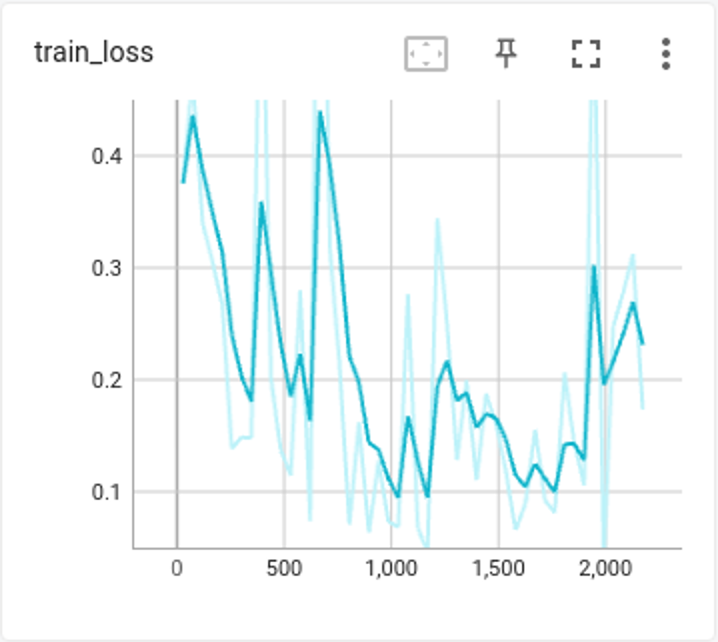

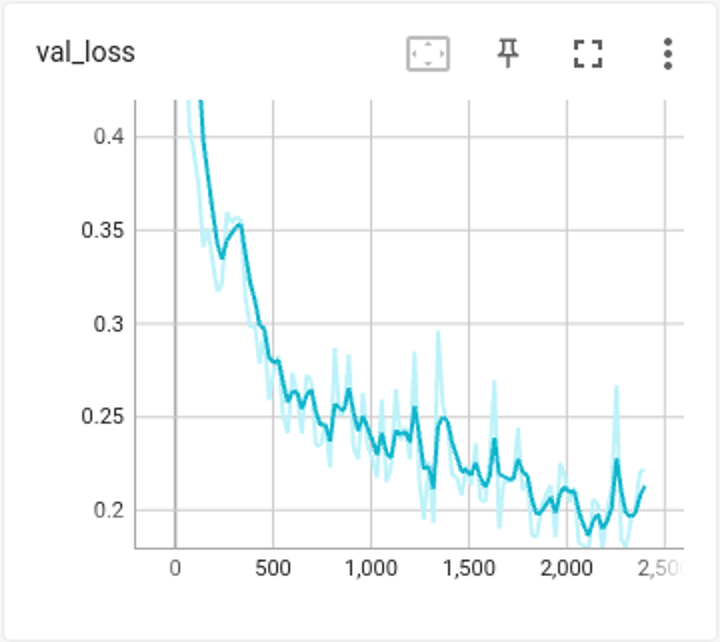